# Preprocessing EEG Data

Congratulations, you have recorded your first EEG experiment! Are you ready to explore the neural signatures of \<the cognitive functions elicited in your experiment\>? Oh wait, that data looks terrible - what's happening here?

Raw EEG recordings can be affected by noise coming from a number of different sources. The recording hardware is sensitive to imperfect setup and there are a lot of electric signals besides brain activity that it may pick up. So, we will have to get cleaning before we can analyze! Some known types of noice in EEG recordings are:

1. Drift (electrode movement or changes in impedance)
2. Bad channels (high impedance or faulty hardware)
3. Eye movement artifacts (low frequency / frontal)
4. Muscle / movement artifacts (high or low frequency / global)
5. Line artifacts (electric pulses from power source)

Below is some prepared code that reads the original recordings from the Brainvision EEG system, checks for bad channels and other artifacts and marks them, then uses a sophisticated process involving linear algebra and machine learning classifiers to try to remove the artifacts as best as possible without degrading the signals of interest. No data clean up is perfect, our goal is to improve the Signal-to-Noise-Ratio (SNR) while keeping the cognitive signatures in our data intact.

## Supporting code
These are imports that make helpful programming libraries available as well as a few functions that compartmentalize the preprocessing steps into easier to use chunks.

In [120]:
import mne
from glob import glob as ls
import matplotlib.pyplot as plt
import numpy as np
from mne_icalabel import label_components
from mne.preprocessing import ICA
chs = ['AF3', 'AF4', 'AF7', 'AF8', 'AFz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'Fz','FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FT7', 'FT8', 'FCz',
 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'T7', 'T8', 'Cz', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'TP7', 'TP8', 'CPz',
 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'Pz', 'PO3', 'PO4', 'PO7', 'PO8', 'POz', 'O1', 'O2', 'Oz']
sel = ['F1', 'F2', 'F3', 'F4', 'TP8', 'CPz', 'P1', 'P2', 'P3', 'P4']

In [96]:
def minmax_zscore(inst,axis='channels',threshold=3.,max_iter=1,mask=lambda x:[False]*len(x)):
    if axis == 'time':
        inst = np.mean(inst.get_data(),axis=1)
    else:
        inst = inst.get_data()
    X = np.max(inst, axis=-1) - np.min(inst, axis=-1)
    mask = mask(X)
    for _ in range(max_iter):
        Y = np.ma.masked_array(X,mask)
        mn = np.mean(Y); sd = np.std(Y)
        mask = np.abs((X-mn)/sd)>3
    return mask

def fix_channels(raw,threshold=3,max_iter=1):
    r = raw.copy()
    r.info['bads'] = np.unique(np.concatenate((np.array(r.info['bads']),np.array(r.ch_names)[minmax_zscore(r,threshold=threshold,max_iter=max_iter)]))).tolist()
    return r

def artefact_rejection(r,threshold=3.,max_iter=3,duration=.5,stimulation=False):
    mask = lambda x:[True]*int(np.floor(len(x)/2))+[False]*(len(x)-int(np.floor(len(x)/2))) if stimulation else lambda x: [False]*len(x)
    epo = mne.make_fixed_length_epochs(r,duration=duration,reject_by_annotation=False)
    bad_starts = epo.events[minmax_zscore(epo,axis='time',threshold=threshold,max_iter=max_iter,mask=mask),0]/epo.info['sfreq']
    return mne.Annotations(bad_starts,duration,"bad_minmax_zscore",orig_time=r.annotations.orig_time)

def clean_r(r):
    r_ic = r.copy().filter(1.,100,n_jobs=-1).crop(1000,2000)
    ica = ICA(n_components=0.99, method='infomax', fit_params=dict(extended=True), random_state=97, max_iter="auto")
    ica.fit(r_ic)
    labels = label_components(r_ic, ica, method='iclabel')
    ic_labels = labels['labels']
    ica.exclude = [i for i,l in enumerate(ic_labels) if l not in ["brain", "other"]]
    r = ica.apply(r)
    r.interpolate_bads(reset_bads=False)
    r,q = mne.set_eeg_reference(r)
    return (r.filter(.5,40,n_jobs=-1),ica)

## Running it on our EEG recordings
The first line below scans for Brainvision recordings in a folder, you'll adapt it to point at your own data. Every Brainvision recording comes with 3 files:

1. The `.eeg` file contains the actual recording
2. The `.vhdr` file is the header or table of content
3. The `.vmrk` file is a register for the event codes used in your experiment

To load a recording, you'll look for the TOC and tell MNE to load it. The first things we clean up are drift (1) and line noise (2). Then we use a statistical method to find really bad channels, that have much larger amplitudes than other channels (3).

Once the data has been cleaned of the worst artifacts, we normalize the signals across all channels by re-referencing them to the global average (4). Now we use statistics to find intervals in the signal that look much worse than the rest (5). All of these steps help improve the result from the central part of our preprocessing:

With that, we can run our ICA (independent component analysis) decomposition and remove the components that represent any kind of well-defined noise from the list above (6).

Now, we repeat the statistical artifact detection on the cleaned up data to mark any noise that couldn't be removed. We save the cleaned up data in a new MNE-specific format (`-raw.fif.gz`).

In [112]:
files = [f for f in sorted(ls("Data/s03/*.vhdr"))];files

['Data/s03/dmss03.vhdr']

In [113]:
r_ex = {}
for f in files:
    r = mne.io.read_raw_brainvision(f,preload=True,eog=('TVEOG','BVEOG','LHEOG','RHEOG')).pick(['eeg','eog']);
    r_ex['original'] = r.copy().crop(1000,1100)
    r = r.pick(chs)
    if r.info['dig']==None:
        r.set_montage('easycap-M1');
    # 1. & 2. Drift and line noise removal
    r = r.filter(1,100).notch_filter((60,120,180,240))
    # 3. Bad channel detection
    r = fix_channels(r,3,3)
    # 4. Re-referencing
    r = r.set_eeg_reference("average")
    r_ex['filtered'] = r.copy().crop(1000,1100)
    old_bads = r.info['bads']
    # 5. Statistical artifact detection
    r.set_annotations(r.annotations + artefact_rejection(r))
    # 6. ICA-based noise removal
    r,ica = clean_r(r)
    r = fix_channels(r,max_iter=3)
    r.info['bads'] = np.unique(old_bads+r.info['bads']).tolist()
    r.set_annotations(r.annotations + artefact_rejection(r))
    r.save(f[:-5]+"-raw.fif.gz",overwrite=True)
    ica.save(f[:-5]+"-ica.fif.gz",overwrite=True)
    r_ex['cleaned'] = r.copy().crop(1000,1100)
    r_ex['ica'] = ica

Extracting parameters from Data/s03/dmss03.vhdr...
Setting channel info structure...
Reading 0 ... 7643799  =      0.000 ...  7643.799 secs...


/var/folders/9z/wdzscs1d11s28758n1wm54wh00_b1l/T/ipykernel_68130/2639340612.py:3: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  r = mne.io.read_raw_brainvision(f,preload=True,eog=('TVEOG','BVEOG','LHEOG','RHEOG')).pick(['eeg','eog']);
/var/folders/9z/wdzscs1d11s28758n1wm54wh00_b1l/T/ipykernel_68130/2639340612.py:3: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['TVEOG', 'LHEOG', 'RHEOG', 'BVEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  r = mne.io.read_raw_brainvision(f,preload=True,eog=('TVEOG','BVEOG','LHEOG','RHEOG')).pick(['eeg','eog']);


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 3301 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

EEG channel type

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  55 out of  58 | elapsed:    5.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    5.6s finished


Fitting ICA to data using 55 channels (please be patient, this may take a while)
Omitting 2500 of 1000001 (0.25%) samples, retaining 997501 (99.75%) samples.
Selecting by explained variance: 25 components
Computing Extended Infomax ICA
Fitting ICA took 47.3s.
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 13 ICA components
    Projecting back using 55 PCA components
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 55 sensor positions
Interpolating 3 sensors
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  55 out of  58 | elapsed:    5.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    5.5s finished


Not setting metadata
15287 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15287 events and 500 original time points ...
0 bad epochs dropped
Writing /Users/fbaumg/Documents/Obsidian/Courses/PS329/Data/s03/dmss03-raw.fif.gz
Closing /Users/fbaumg/Documents/Obsidian/Courses/PS329/Data/s03/dmss03-raw.fif.gz
[done]
Writing ICA solution to /Users/fbaumg/Documents/Obsidian/Courses/PS329/Data/s03/dmss03-ica.fif.gz...


## How did we change the data?

Let's look at some figures to understand how we transformed the noisy EEG recording into a cleaner version of itself. The first figure below is the recording as it came from the EEG hardware (which did some initial referencing and filtering, but nothing too involved). Notice the large amplitudes, the high frequency noise, and the diagonal movements (drift) of the signal from individual channels.

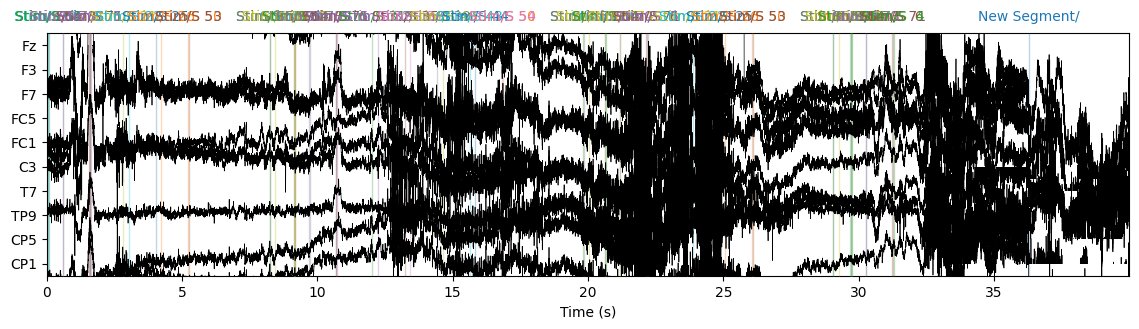

In [122]:
fig = r_ex['original'].plot(duration=40, n_channels=10, show_scalebars=False, show_scrollbars=False, show=False); fig.set_size_inches(12,3); fig

After removing drift and line noise, and detecting bad channels, our data already looks much less chaotic. The light grey coloration indicates a channel marked as noisy - do you notice it looks different?

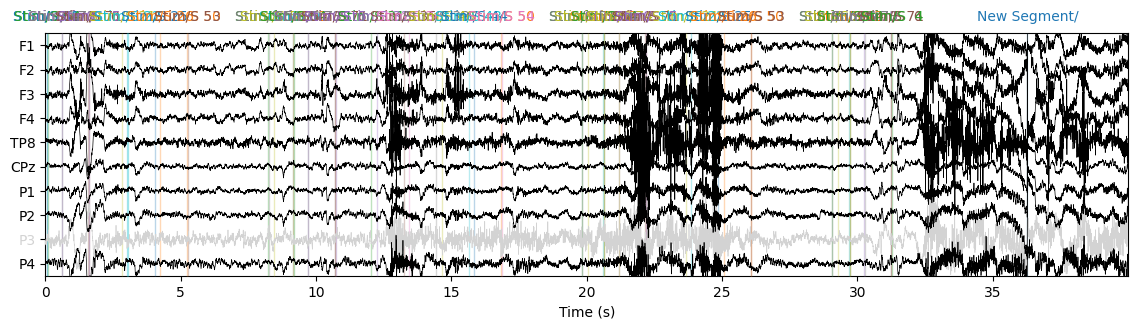

In [123]:
fig = r_ex['filtered'].plot(picks=sel, duration=40, show_scalebars=False, show_scrollbars=False, show=False); fig.set_size_inches(12,3); fig

With the ICA-based artifact removal done, we're looking at a much improved recording. While there are still some large amplitudes and intervals with high frequency noise, we have reached a point where we're likely to be able to detect signatures of cognitive processes in the data. The remainign artifacts, we'll mark (in red) and exclude the affected areas from our analysis. Data cleaning is a compromise in the end, and this may be as good as it gets. 

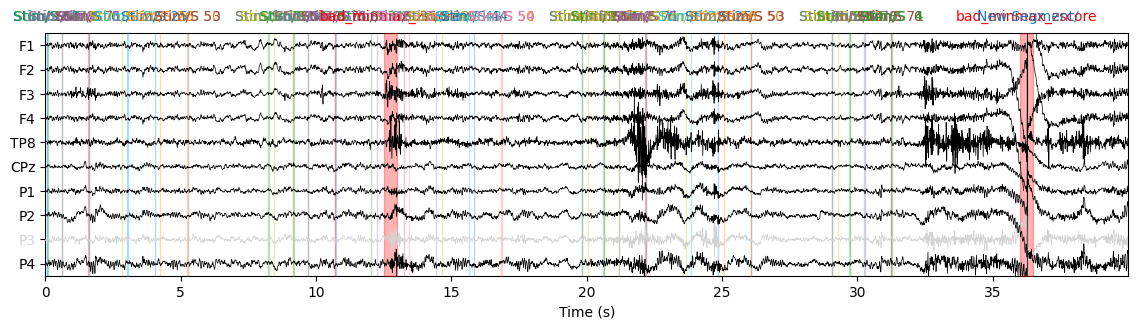

In [124]:
fig = r_ex['cleaned'].plot(picks=sel, duration=40, show_scalebars=False, show_scrollbars=False, show=False); fig.set_size_inches(12,3); fig

If you're curious how the ICA-based artifact removal works -- we identify and decompose the EEG signal into separate spatial regions that contribute coherent signal components to the complete signal. Some of these components behave show stereotypical properties of known sources of noise. We remove those components and reassemble the signal without them. Below is an example of this - the components with grey labels have been identified as noise.

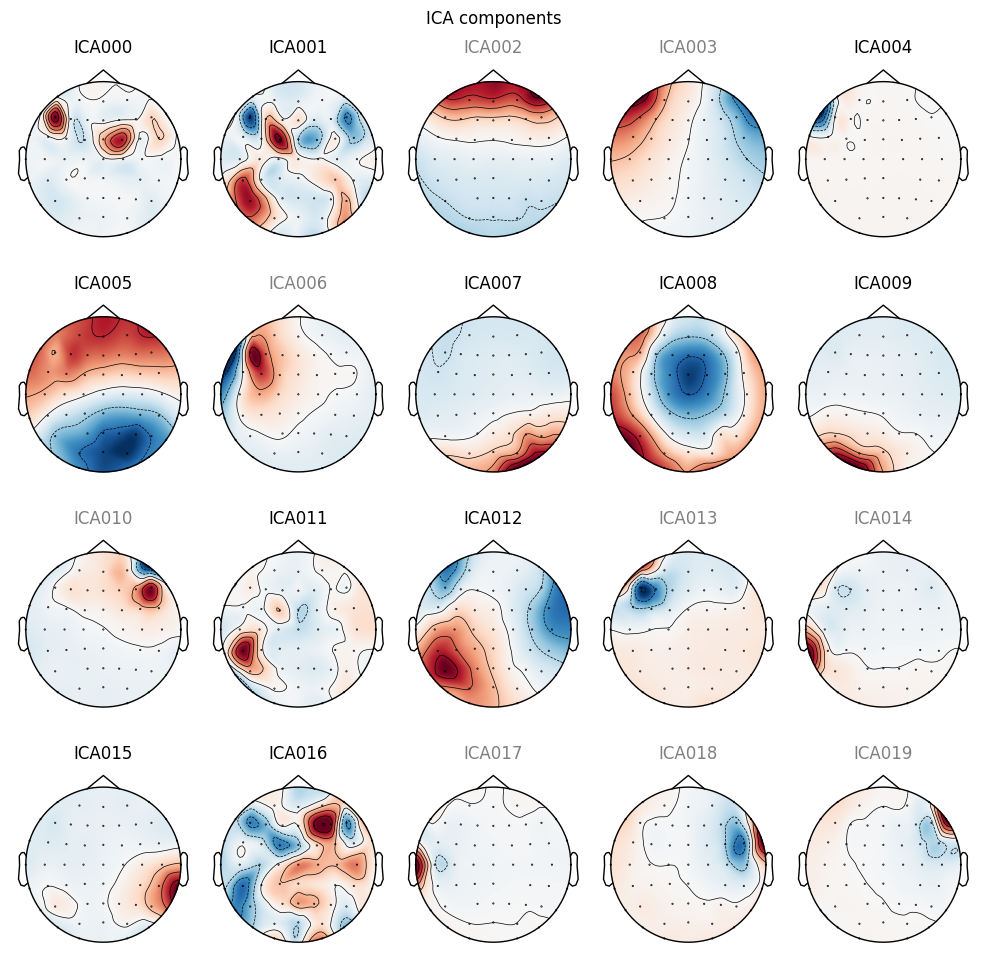

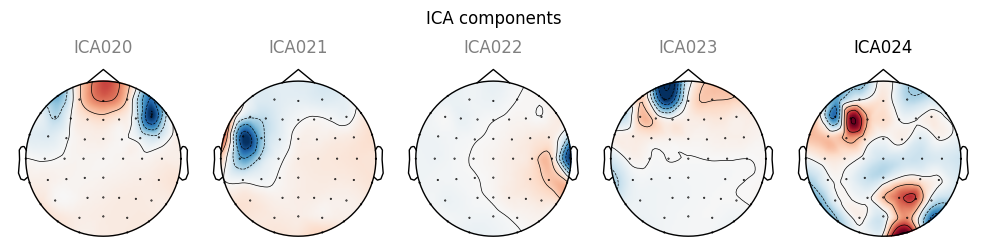

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x260.5 with 5 Axes>]

In [126]:
plt.close('all'); fig = r_ex['ica'].plot_components(); fig